In [1]:
#This Notebook presents a code to do a decompositon onto Alfven Slow and Fast modes
#Darryl Seligman version3 9/11/18
#Adapted from version of code by Jonathan Squire
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import *
import sys
sys.path.append('/Users/darrylseligman/Desktop/Flatiron/Phil/Initial_Magnetic_Simulations/PFH_python/pfh_python')
from get_particle_hsml_ngb import *
from grain_density_from_snapshot import *
from example_plotting_routine import *
def mode_decomp(Vx,Vy,Vz,beta):
    #Form grid of K
    n=Vx.shape[0]
    
    N=[n,n,n]
    L=[1.,1.,1.]
    if(n%2==0):
        b=np.arange(0,N[0]/2)
        bb = np.linspace(-N[0]/2.,-1,N[0]/2)
    else:
        print "hello"
        b=np.arange(0,N[0]/2)
        bb = np.linspace(-N[0]/2.,-1.5,N[0]/2)
        bb=np.append(bb,[.5])
    #Form k-space vectors for each dimension [0 1 2 3 ... N/2-1 -N/2 -N/2+1 ... -2 -1]*2*pi/L
    
    kx=  2*np.pi*1j/L[0]*np.concatenate((b,bb))
    ky=  2*np.pi*1j/L[1]*np.concatenate((b,bb))
    kz=  2*np.pi*1j/L[2]*np.concatenate((b,bb))
   
    #print kx.shape
    #xg=np.linspace(0.,1.,n)
    #yg=np.linspace(0.,1.,n)
    #zg=np.linspace(0.,1.,n)
    #x,y,az=np.meshgrid(xg,yg,zg,indexing='ij')
    #3D arrays of k-space grid
    KX,KY,KZ= np.meshgrid(kx,ky,kz)#,indexing='ij')
    #grid of |K|, kperp (B0 is in x direction) and k_hat
    Kmag = np.sqrt(abs(KX**2+KY**2+KZ**2))
    Kperp = np.sqrt(abs(KY**2+KX**2))
    #Kmag[0]=1.
    khx = KX/Kmag;
    khy = KY/Kmag;
    khz = KZ/Kmag;
    #k-Grid for binning the spectra
    kgrid = np.arange(0,max(ky.imag)+2.*np.pi/L[0],2.*np.pi/L[0])

    kgridG = (kgrid[0:kgrid.size-1] +  kgrid[1:kgrid.size])/2;   
    #Get B and V, take fourier transforms  
    fVx = fftn(Vx);
    fVy = fftn(Vy); 
    fVz = fftn(Vz);
    # % Alfvenic part -- part of B and u in k*b_hat direction                                                                                                                                                                      
    #% b_hat is x direction 
    kcbhz = 0;
    kcbhy = (khx);
    kcbhx =  - (khy);
    #Alfvenic part of V, (k*bh).V 
    alfV =  kcbhy*fVy + kcbhx*fVx;
    
    #% Now decompose compressive part into fast and slow                                                                                                                                                                          
    #% I think this is right, but never actually used this seriously  
    
    costh = abs(khz);
    sinth = np.sqrt(1.-costh**2);
    Kperp[Kperp==0]=1.;
    #for strong beta regime A33 - A34
    if(beta>1.e2):
        thx = -sinth*np.sign(KX);
        #thx = sinth*khx;
        Kperp[Kperp==0]=1.;
        thy = costh*(KY/Kperp);
        thz = costh*(KZ/Kperp);
        #% Slow wave part  
        slowV = -thx*fVx - thy*fVy - thz*fVz + costh*sinth/beta*(khx*fVx + khy*fVy + khz*fVz);
        #% Fast wave part  
        fastV = costh*sinth/beta*(thx*fVx + thy*fVy + thz*fVz) + khx*fVx + khy*fVy + khz*fVz;
    #General beta case A29 - A30
    else:
        
        alpha = beta/2.
        
        D = np.array(((1.+alpha)**2-4.*alpha*costh*costh),dtype=complex)
        #print D
        #print KY/Kperp
        slowV = (-1.+alpha-np.sqrt(D))*(khz*fVz)+(1.+alpha-np.sqrt(D))*((KY/Kperp)*fVy + (KX/Kperp)*fVx)
        fastV= (-1.+alpha+np.sqrt(D))*(khz*fVz)+(1.+alpha+np.sqrt(D))*((KY/Kperp)*fVy + (KX/Kperp)*fVx)
        #slowV = (-1.+alpha-np.sqrt(D))*(khz*fVz)+(1.+alpha-np.sqrt(D))*(khy*fVy + khx*fVx)
        #fastV= (-1.+alpha+np.sqrt(D))*(khz*fVz)+(1.+alpha+np.sqrt(D))*(khy*fVy + khx*fVx)
        #slowV = (-1.+alpha-np.sqrt(D))*(KX*fVx)+(1.+alpha-np.sqrt(D))*(KY*fVy + KZ*fVz)
        #fastV= (-1.+alpha+np.sqrt(D))*(KX*fVx)+(1.+alpha+np.sqrt(D))*(KY*fVy + KZ*fVz)
        #print (-1.+alpha+np.sqrt(D))
        #print fastV
        #-thx*fVx - thy*fVy - thz*fVz + costh*sinth/beta*(khx*fVx + khy*fVy + khz*fVz);
    alfVIso = spect1D((alfV),Kmag,kgrid)
    #VIso = spect1D(fVx,Kmag,kgrid) + spect1D(fVy,Kmag,kgrid) + spect1D(fVz,Kmag,kgrid); #% velocity spectrum
    #SpFIso =spect1D(cmpVx,Kmag,kgrid) + spect1D(cmpVy,Kmag,kgrid) + spect1D(cmpVz,Kmag,kgrid); #% Compressive part (slow+fast) of the velocity
    slowVIso = spect1D((slowV),Kmag,kgrid); #% Slow mode part
    fastVIso = spect1D((fastV),Kmag,kgrid); #% Fast mode part
    #VIso1 = spect1D((thetapart),Kmag,kgrid)
    #VIso2 = spect1D((khatpart),Kmag,kgrid)
    return(kgridG,alfVIso,fastVIso,slowVIso)
def spect1D(v1,K,kgrid):
    # % Function to find the spectrum <v1^2>,
    #% K is the kgrid associated with v1
    #% kgrid is the grid for spectral shell binning
    nk = len(kgrid)-1;
    print nk
    out1 = np.zeros((nk))
    NT2 = K.size**2;
    for kk in np.arange(nk):

        out1[kk]= np.sum(abs(v1[(K<=kgrid[kk+1]) & (K>=kgrid[kk])])**2 )/NT2;

    return out1    

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


63
63
63


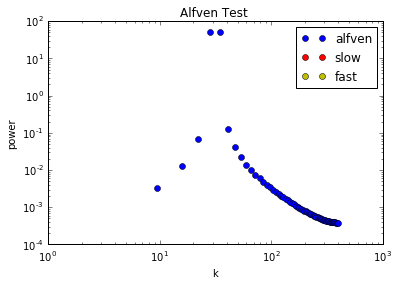

In [11]:
#Test for a linear purely Alfvenic Mode
#can experimenet with changing beta
beta=1.;
#experiment with changing NN - changes peak of power
NN=5.
n=128
xg=np.linspace(0.,1.,n)
yg=np.linspace(0.,1.,n)
zg=np.linspace(0.,1.,n)
x,y,z=np.meshgrid(xg,yg,zg)#,indexing='ij')
Vx = np.zeros((n,n,n))
Vz = np.zeros((n,n,n))#+.01*np.random.rand(n,n,n)

Vy = 10.1*np.sin(2.*NN*np.pi*x)

kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)
#plt.loglog(kgridG,viso,'ko',label='viso')
plt.loglog(kgridG,alfVIso,'bo',label='alfven')
plt.loglog(kgridG,slowVIso,'ro',label='slow')
plt.loglog(kgridG,fastVIso,'yo',label='fast')
plt.legend()
plt.xlabel('k')
plt.ylabel('power')
plt.title('Alfven Test ')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


63
63
63


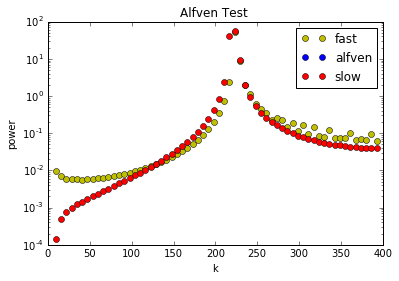

In [16]:
#now test a slow mode and fast mode
beta=1.;
#units alfven speed = 1
NN = 35.

xg=np.linspace(0.,1.,n)
yg=np.linspace(0.,1.,n)
zg=np.linspace(0.,1.,n)
x,y,z=np.meshgrid(xg,yg,zg)#,indexing='ij')

xpart=0.#.01
zpart=np.sqrt(1.-xpart**2)
Vy = np.zeros((n,n,n))
#Vy = 10.1*np.sin(10.*NN*np.pi*z)

#Vx = np.sqrt(2.)/(2.*np.pi)/B0*omega*A*np.cos(2.*NN*np.pi/np.sqrt(2.)*(xpart*x+zpart*z))/NN
#Vz = A*np.cos(2.*NN*np.pi/np.sqrt(2.)*(xpart*x+zpart*z))
Vz =np.zeros((n,n,n))

#Vy = A*np.sin(2.*NN*np.pi*x)
Vz = 10.1*np.sin(2.*NN*np.pi*(xpart*x+zpart*z))
#Vz = 8.1*np.sin(2.*NN*np.pi*(xpart*x+zpart*z))


kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)
plt.plot(kgridG,fastVIso,'yo',label='fast')
plt.plot(kgridG,alfVIso,'bo',label='alfven')
plt.plot(kgridG,slowVIso,'ro',label='slow')

plt.yscale('log')

plt.legend()
plt.xlabel('k')
plt.ylabel('power')
plt.title('Slow Fast Compressible Mode Test ')

Keys: [u'Desired_Number_Of_Neighbors', u'Mass_Density_List_Of_Gas_NeighborsVX', u'Mass_Density_List_Of_Gas_NeighborsVY', u'Mass_Density_List_Of_Gas_NeighborsVZ', u'Minimum_Smoothing_Length_Allowed', u'Number_Of_Simulation_Dimensions', u'Periodic_BoxSize', u'Smoothing_Length_List_Of_Gas_NeighborsVX', u'Smoothing_Length_List_Of_Gas_NeighborsVY', u'Smoothing_Length_List_Of_Gas_NeighborsVZ', u'Snapshot_Directory', u'Snapshot_Number', u'Snapshot_Time', u'Total_Number_Of_Dust_Particles', u'Total_Number_Of_Gas_Particles', u'x_grid', u'y_grid', u'z_grid']
hello


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


62
62
62


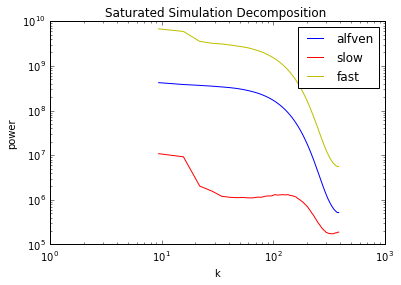

In [17]:
#
infi=h5py.File('/Users/darrylseligman/Desktop/Flatiron/Phil/Initial_Magnetic_Simulations/jono_default_params/b0_N64/output_wheeler/dust_ALFVEN_snap_0946.h5','r') # (defined same as above) 
print("Keys: %s" % infi.keys())
#h_g = np.array(infi["Smoothing_Length_List_Of_Gas_Neighbors"]) # this will act like a normal vector: h_g[:] for all elements
#h_d=np.array(infi["Smoothing_Length_List_Of_Dust_Neighbors"])
#read the list of B and V
#B0=np.array(infi["Mass_Density_List_Of_Gas_Neighbors_B0"])
#B1=np.array(infi["Mass_Density_List_Of_Gas_Neighbors_B1"])
#B2=np.array(infi["Mass_Density_List_Of_Gas_Neighbors_B2"])

V0=np.array(infi["Mass_Density_List_Of_Gas_NeighborsVX"])
V1=np.array(infi["Mass_Density_List_Of_Gas_NeighborsVY"])
V2=np.array(infi["Mass_Density_List_Of_Gas_NeighborsVZ"])
xgrid=np.array(infi["x_grid"])
#nngb_d_v1=np.array(infi["Mass_Density_List_Of_Dust_Neighbors_v1"])
#nngb_g_v1=np.array(infi["Mass_Density_List_Of_Gas_Neighbors_v1"])

infi.close() 

kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(V0,V1,V2,1.)

plt.loglog(kgridG,alfVIso,'b',label='alfven')
plt.loglog(kgridG,slowVIso,'r',label='slow')
plt.loglog(kgridG,fastVIso,'y',label='fast')
plt.legend()
plt.xlabel('k')
plt.ylabel('power')
plt.title('Saturated Simulation Decomposition ')